In [1]:
import librosa
from librosa import feature
import numpy as np

In [98]:
x, sr=librosa.load("mixed_data\mixed_clip_08_calm_10_angry_13_happy_20_sad.wav")

In [109]:
nonMuteSections = librosa.effects.split(x, top_db=70)  # split audio with any audio signal lesser than 20db as mute
nonMuteSections

array([[     0, 259584],
       [260096, 271872],
       [274944, 317440],
       [320512, 321024],
       [321536, 322048],
       [323072, 326656],
       [348672, 385536]])

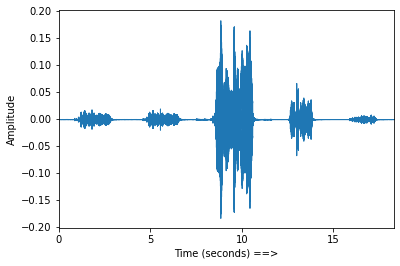

In [101]:
from librosa import display
import matplotlib.pyplot as plt
plt.figure()
librosa.display.waveplot(y=x, sr=sr)
plt.xlabel("Time (seconds) ==>")
plt.ylabel("Amplitude")
plt.show()

In [66]:
def get_feature_vector(y, sr):
    feature_vector = []
    
    # multi-dim features
    feature_vector.extend(np.mean(feature.mfcc(y=y, sr=sr, n_mfcc=13), axis=1))
    feature_vector.extend(np.mean(feature.chroma_stft(y=y, sr=sr), axis=1))
    feature_vector.extend(np.mean(feature.spectral_contrast(y=y, sr=sr), axis=1))
    feature_vector.extend(np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr),axis=1))
    
    # single-dim features with special requirements
    feature_vector.append(np.mean(feature.rms(y=y)))
    feature_vector.append(np.mean(feature.zero_crossing_rate(y=y)))
    feature_vector.extend([np.mean(x) for x in librosa.piptrack(y=y, sr=sr)])
    
    # single-dim features
    feat_list = [
        librosa.onset.onset_strength,
        feature.spectral_rolloff,
        feature.melspectrogram,
        feature.spectral_centroid,
        feature.spectral_bandwidth
    ]
    
    for temp_func in feat_list:
        feature_vector.append(np.mean(temp_func(y=y, sr=sr)))
    
    return feature_vector

In [85]:
audio_features = []
for i in range(nonMuteSections.shape[0]):
   print(nonMuteSections[i][0])
   slice=x[nonMuteSections[i][0]-15000:nonMuteSections[i][1]+15000]
   print(slice)

   feature_vector = get_feature_vector(slice, sr)
   audio_features.append(feature_vector) 

15872
[-2.3635840e-07  3.6738354e-07 -5.4713507e-07 ... -5.9957699e-07
  9.7140730e-07 -1.5731117e-06]
90624
[ 1.1396173e-05  2.1697157e-05  3.2749740e-05 ...  3.9340495e-07
 -4.8244084e-07  5.8181672e-07]
172544
[-1.4240237e-06  2.0258617e-06 -4.0033869e-06 ... -2.8401337e-06
  9.3955305e-06  8.2480210e-06]


In [86]:
len(audio_features[2])

47

In [87]:
def build_siamese_model(inputsize, nlayers=2, nsize=64, emb_dim=100):
    inputs = Input(inputsize)
    x = Dense(nsize, activation='relu')(inputs)
    x = Dropout(0.1)(x)
    for _ in range(nlayers-1):
        x = Dense(nsize, activation='relu')(x)
        x = Dropout(0.1)(x)
    outputs = Dense(emb_dim)(x)
    model = Model(inputs, outputs)
    
    return model

In [88]:
def cosine_similarity(vests):
    x, y = vests
    x = K.l2_normalize(x, axis=-1)
    y = K.l2_normalize(y, axis=-1)
    return K.sum(x * y, axis=-1, keepdims=True)

def cos_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0],1)

In [80]:
# building model
input_shape = len(audio_features[0])
inputA = Input(input_shape)
inputB = Input(input_shape)
featureExtractor = build_siamese_model(input_shape)
featsA = featureExtractor(inputA)
featsB = featureExtractor(inputB)

output_cos = Lambda(cosine_similarity, output_shape=cos_dist_output_shape)([featsA, featsB])
model = Model(inputs=[inputA, inputB], outputs=output_cos)

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [81]:
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Lambda
import tensorflow.keras.backend as K

In [90]:
model.load_weights("models/base_siamese")

In [91]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 47)]         0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 47)]         0           []                               
                                                                                                  
 model_2 (Functional)           (None, 100)          13732       ['input_4[0][0]',                
                                                                  'input_5[0][0]']                
                                                                                                  
 lambda_1 (Lambda)              (None, 1)            0           ['model_2[0][0]',          

In [92]:
model.predict([np.array([audio_features[2]]), np.array([audio_features[0]])])[0][0]

0.99872917

In [97]:
np.array([audio_features[0]]).shape

(1, 47)